Epoch 500 | Reward: -1408.19: 100%|██████████| 500/500 [03:28<00:00,  2.40it/s]   


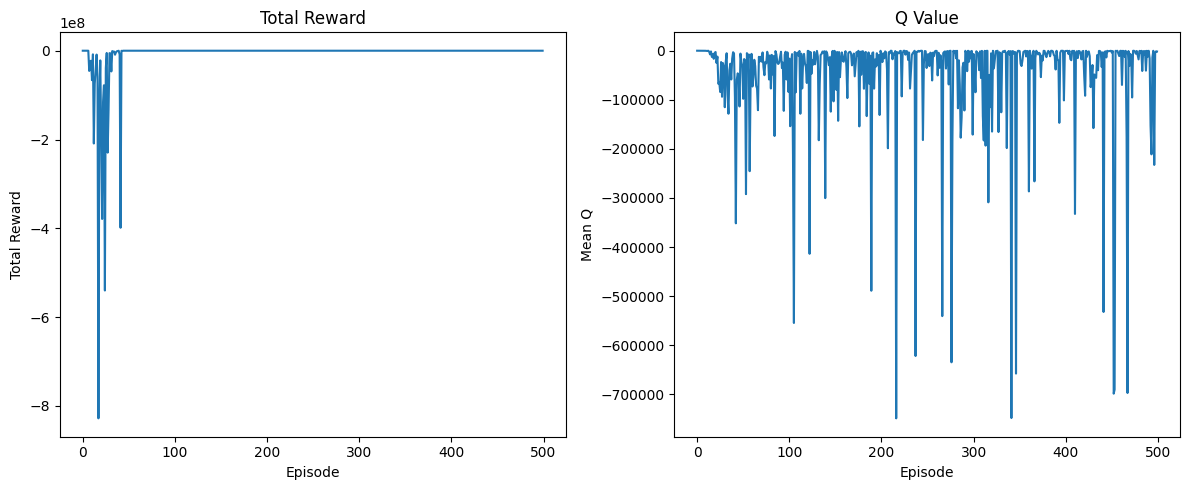

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from pettingzoo import ParallelEnv

# 假设用户已经提供了上述的自定义环境类CustomMAEnvironment
# 此处直接使用用户环境
from env_new.MAenv_2 import CustomMAEnvironment2
# 创建环境
env = CustomMAEnvironment2()

# -------------------------------
# 分散执行、集中训练的多智能体强化学习示例算法（类似MADDPG的思想，但动作为离散，采用集中Q网络进行训练）
# 算法说明：
# 1. 对于每个智能体，有一个独立的actor网络（策略网络），输入为该智能体的局部观测o_i，输出为动作概率分布。
# 2. 对于每个智能体，有一个集中式的critic网络（Q网络），输入为所有智能体的状态（观测合并）和所有动作的one-hot表示（或离散索引），输出该智能体针对每个可能动作的Q值。
# 3. 在训练时，我们将所有智能体的经验统一存入一个全局的重放缓冲区，然后集中更新critic和actor。critic的输入是全局信息（所有智能体的obs和actions），从而实现集中训练。
# 4. 执行时各智能体仅依赖自己的actor策略来选动作，实现分散执行。

# 注意：不同智能体的观测维度不同，需要为每个智能体独立构建actor和critic输入维度。
# 在critic中，我们将所有智能体的obs和当前joint action拼接到一起作为输入。
# 在actor中，只输入该智能体自己的obs。

# -------------------------------
# 准备工作

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agents = env.agents
num_agents = len(agents)
action_spaces = [env.action_space(agent) for agent in agents]
obs_dict = env.reset()  # 重置环境获取初始obs
obs_shapes = [obs_dict[agent].shape[0] for agent in agents]  # 每个智能体的观测维度
action_dims = [action_spaces[i].n for i in range(num_agents)]  # 每个智能体的动作数（离散）
max_action_dim = max(action_dims)

# 对于critic，输入为所有obs拼接后的维度加上所有动作的one-hot表示长度
total_obs_dim = sum(obs_shapes)
# 我们将所有智能体的动作采用one-hot表示拼接起来，长度为sum(action_dims)
total_action_dim = sum(action_dims)

# -------------------------------
# 建立网络结构

def mlp(input_dim, output_dim, hidden_sizes=[64,64], activation=nn.ReLU):
    layers = []
    in_dim = input_dim
    for h in hidden_sizes:
        layers.append(nn.Linear(in_dim, h))
        layers.append(activation())
        in_dim = h
    layers.append(nn.Linear(in_dim, output_dim))
    return nn.Sequential(*layers)


class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes=[64,64]):
        super(Actor, self).__init__()
        self.net = mlp(obs_dim, act_dim, hidden_sizes)

    def forward(self, obs):
        # 输出未归一化的logits，然后用softmax变成概率分布
        logits = self.net(obs)
        return torch.softmax(logits, dim=-1)


class Critic(nn.Module):
    def __init__(self, total_obs_dim, total_act_dim, agent_act_dim, hidden_sizes=[128,128]):
        super(Critic, self).__init__()
        # Critic的输出是针对单个agent，对每个possible action输出Q值
        # 输入维度：所有agent的obs合并 + 所有agent的action的one-hot
        # 输出维度：该agent的动作数
        self.agent_act_dim = agent_act_dim
        self.net = mlp(total_obs_dim + total_act_dim, agent_act_dim, hidden_sizes)

    def forward(self, global_obs, global_action):
        # global_obs: [batch, total_obs_dim]
        # global_action: [batch, total_action_dim]
        x = torch.cat([global_obs, global_action], dim=-1)
        q_values = self.net(x)
        return q_values


# 为每个智能体建立actor与critic
actors = []
critics = []
target_critics = []
for i in range(num_agents):
    actor = Actor(obs_shapes[i], action_dims[i]).to(device)
    actors.append(actor)

    critic = Critic(total_obs_dim, total_action_dim, action_dims[i]).to(device)
    critics.append(critic)

    target_critic = Critic(total_obs_dim, total_action_dim, action_dims[i]).to(device)
    target_critic.load_state_dict(critic.state_dict())
    target_critics.append(target_critic)

actor_optims = [optim.Adam(actor.parameters(), lr=1e-3) for actor in actors]
critic_optims = [optim.Adam(critic.parameters(), lr=1e-3) for critic in critics]

# -------------------------------
# 重放缓冲区

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, obs_list, actions, rewards, next_obs_list, dones):
        # obs_list: [obs_agent_0, obs_agent_1, ...]
        # actions: dict {agent_i: a_i}, a_i是整数动作
        # rewards: dict {agent_i: r_i}
        # next_obs_list: 同obs_list
        # dones: dict {agent_i: bool}
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (obs_list, actions, rewards, next_obs_list, dones)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        obs_batch = []
        actions_batch = []
        rewards_batch = []
        next_obs_batch = []
        dones_batch = []
        for idx in batch:
            obs_list, actions, rewards, next_obs_list, dones = self.buffer[idx]
            obs_batch.append(obs_list)
            actions_batch.append(actions)
            rewards_batch.append(rewards)
            next_obs_batch.append(next_obs_list)
            dones_batch.append(dones)
        return obs_batch, actions_batch, rewards_batch, next_obs_batch, dones_batch

    def __len__(self):
        return len(self.buffer)

buffer = ReplayBuffer(200000)

# 将obs转为torch张量
def to_torch(x):
    return torch.tensor(x, dtype=torch.float32, device=device)

def one_hot_action(action_idx, action_dim):
    a = np.zeros(action_dim)
    a[action_idx] = 1.0
    return a

# -------------------------------
# 训练超参数
epochs = 500
episodes_per_epoch = 1
batch_size = 64
gamma = 0.95
tau = 0.01  # 软更新参数
update_after = 500  # 在收集一定数据后再更新
update_every = 50
epsilon = 0.3  # 简单ε贪心探索，为了增加动作多样性
epsilon_decay = 0.999
min_epsilon = 0.05

reward_history = []
q_value_history = []

# -------------------------------
# 工具函数
def soft_update(target, source, tau=0.01):
    for t_param, s_param in zip(target.parameters(), source.parameters()):
        t_param.data.copy_(tau * s_param.data + (1 - tau) * t_param.data)

def get_joint_obs_action(obs_list, actions):
    # obs_list: [obs_agent_0, obs_agent_1, ...] 每个是np.array
    # actions: dict {agent_i: action_idx}
    # 返回拼接后的obs与action one-hot
    # obs拼接
    full_obs = np.concatenate(obs_list, axis=0)
    # action one-hot拼接
    one_hot_actions = []
    for i, agent in enumerate(agents):
        a = actions[agent]
        oh = one_hot_action(a, action_dims[i])
        one_hot_actions.append(oh)
    full_action = np.concatenate(one_hot_actions, axis=0)
    return full_obs, full_action

# -------------------------------
# 开始训练

progress = tqdm(range(epochs))
total_steps = 0
for epoch in progress:
    episode_rewards = 0
    obs_dict = env.reset()
    done = False
    # 将obs转为list以便处理
    obs_list = [obs_dict[agent] for agent in agents]

    while True:
        total_steps += 1
        # 策略选择动作（分散执行）
        actions = {}
        with torch.no_grad():
            for i, agent in enumerate(agents):
                # 当前obs
                o = to_torch(obs_list[i]).unsqueeze(0)  # [1, obs_dim]
                probs = actors[i](o)
                probs = probs.cpu().numpy().squeeze(0)
                # ε-贪心选择动作
                if np.random.rand() < epsilon:
                    a = np.random.randint(action_dims[i])
                else:
                    a = np.random.choice(action_dims[i], p=probs)
                actions[agent] = a

        # 环境执行
        next_obs_dict, rewards, dones, infos = env.step(actions)
        next_obs_list = [next_obs_dict[agent] for agent in agents]

        episode_rewards += sum(rewards.values())
        done = any(dones.values())  # 如果任一agent done则episode结束

        # 存入buffer
        buffer.push(obs_list, actions, rewards, next_obs_list, dones)

        obs_list = next_obs_list

        # 更新网络
        if len(buffer) > update_after and total_steps % update_every == 0:
            # 抽样训练
            obs_batch, actions_batch, rewards_batch, next_obs_batch, dones_batch = buffer.sample(batch_size)

            # 准备训练数据
            # 将数据转为tensor
            # 对于critic:
            # Q_i( O, A ), O和A是所有agents的obs和action
            # target Q_i = r_i + gamma * Q_i'( O', A' ) 其中A'来自target actor的选择。
            # 我们需要先用target actor选取下一个动作，然后计算target critic的Q值。

            # 先构建batch中的全局obs和action
            obs_tensor = []
            act_tensor = []
            next_obs_tensor = []
            next_act_tensor = []
            rew_tensor = []
            done_tensor = []

            for b in range(batch_size):
                # 当前
                full_obs, full_act = get_joint_obs_action(obs_batch[b], actions_batch[b])
                obs_tensor.append(full_obs)
                act_tensor.append(full_act)

                # 下一步动作由当前actor决定（集中训练时可用target actor）
                # 这里我们简单用当前actor来近似下一步动作选择，也可添加target actor来选择动作
                # 更严格的MADDPG应使用target actor
                # 此处为了简化，就直接使用当前actor选择下个动作（或者也可使用贪婪动作）
                with torch.no_grad():
                    next_actions = []
                    for i2 in range(num_agents):
                        o2 = to_torch(next_obs_batch[b][i2]).unsqueeze(0)
                        probs2 = actors[i2](o2)
                        a2 = torch.argmax(probs2, dim=-1).item()  # 贪婪选择下步动作
                        next_actions.append((a2))

                    full_next_obs, full_next_act = get_joint_obs_action(next_obs_batch[b],
                                                                        {agents[i3]: next_actions[i3] for i3 in range(num_agents)})
                next_obs_tensor.append(full_next_obs)
                next_act_tensor.append(full_next_act)

                # reward 和 done
                # 我们对每个agent单独训练Q_i，所以reward要分agent处理
                # 暂时先收集
                rw = [rewards_batch[b][agent] for agent in agents]
                dn = [dones_batch[b][agent] for agent in agents]

                rew_tensor.append(rw)
                done_tensor.append(dn)

            obs_tensor = to_torch(np.array(obs_tensor))  # [batch, total_obs_dim]
            act_tensor = to_torch(np.array(act_tensor))  # [batch, total_action_dim]
            next_obs_tensor = to_torch(np.array(next_obs_tensor))  
            next_act_tensor = to_torch(np.array(next_act_tensor))
            rew_tensor = to_torch(np.array(rew_tensor))  # [batch, num_agents]
            done_tensor = to_torch(np.array(done_tensor).astype(np.float32))

            # 更新critic与actor
            # 更新critic
            q_values_list = []
            target_q_values_list = []
            for i_agent in range(num_agents):
                # 当前Q值
                q = critics[i_agent](obs_tensor, act_tensor)  # [batch, action_dims[i_agent]]
                # 当前执行的动作是batch里的动作，需要从act_tensor解析出对应动作
                # 但act_tensor是one-hot，要得到该agent的动作索引需从actions_batch重取
                # 不过我们已经用act_tensor作为one-hot，不方便直接索引q
                # 我们必须从actions_batch取出该agent的动作index，然后索引q
                chosen_action_indexes = []
                for b in range(batch_size):
                    chosen_action_indexes.append(actions_batch[b][agents[i_agent]])
                chosen_action_indexes = to_torch(np.array(chosen_action_indexes),).long()
                current_q = q.gather(1, chosen_action_indexes.unsqueeze(1)).squeeze(1)  # [batch]

                # 目标Q值
                with torch.no_grad():
                    # 使用target critic计算下一个状态的Q值
                    target_q = target_critics[i_agent](next_obs_tensor, next_act_tensor)
                    # 下一个动作选择已定（使用了贪婪策略）
                    # 找出next_act_tensor中该agent的动作索引（贪婪选的）
                    # 与上面同理，因为next_act_tensor是one-hot，但我们贪婪动作已知
                    # 我们构造next_action_indexes来索引
                    next_action_indexes = []
                    for b in range(batch_size):
                        # 从next_act_tensor中对应agent提取动作（贪婪动作已定）
                        # 我们在上面通过actors选择的a2存了next_actions
                        # 但是这里为了简单，直接重新计算一遍
                        # 已经计算了next_actions，但没单独存下，需要重复逻辑
                        # 简化：从next_act_tensor恢复动作index
                        # next_act_tensor维度[batch, sum(action_dims)]
                        # 我们知道各agent动作维度，i_agent对应的动作维度的offset
                        offset = sum(action_dims[:i_agent])
                        a_slice = next_act_tensor[b, offset:offset+action_dims[i_agent]].cpu().numpy()
                        a_idx = np.argmax(a_slice)
                        next_action_indexes.append(a_idx)
                    next_action_indexes = to_torch(np.array(next_action_indexes)).long()

                    next_q = target_q.gather(1, next_action_indexes.unsqueeze(1)).squeeze(1) # [batch]

                    # 目标 y = r + gamma * (1 - done) * next_q
                    y = rew_tensor[:, i_agent] + gamma * (1 - done_tensor[:, i_agent]) * next_q

                # 计算critic loss
                critic_loss = ((current_q - y)**2).mean()

                critic_optims[i_agent].zero_grad()
                critic_loss.backward()
                critic_optims[i_agent].step()

                # 更新actor
                # actor的目标是最大化Q值，即让actor输出的动作在当前critic下Q值最大
                # 对于actor，需要重新计算actor选择的动作并对critic求梯度上升
                # 此处使用策略梯度近似：对actor参数求梯度，使其选出的动作在critic中Q值更高。
                actor_optims[i_agent].zero_grad()
                # 重新选择动作（使用actor生成概率分布，选择分布参数化）
                # 对于actor梯度更新，我们可以采样一个动作（硬选）或使用期望的连续化近似
                # 因为是离散动作，这里我们采用REINFORCE近似策略梯度不是很合适
                # 更好的方式是使用actor输出的概率分布对Q加权，得到期望Q，然后对actor参数求梯度
                # 把Q值对动作概率分布求期望:
                o_i = obs_tensor[:, sum(obs_shapes[:i_agent]):sum(obs_shapes[:i_agent+1])] # 该agent的obs slice
                # 重新通过actor计算动作分布
                pi = actors[i_agent](o_i)
                # 我们需要该agent在当前状态下对所有动作的Q值:
                with torch.no_grad():
                    all_a = []
                    for act_i in range(action_dims[i_agent]):
                        a_oh = one_hot_action(act_i, action_dims[i_agent])
                        all_a.append(a_oh)
                    all_a = np.array(all_a)
                    # 为计算期望Q值，我们对batch中每个样本进行如下计算:
                    # 对于batch中每个样本，我们需要替换该agent的action部分
                    # 简化方法：对batch循环，用pi中每个动作的概率加权Q值
                    # 效率较低但清晰
                # 重建全动作one-hot(对其他agent使用原动作，对当前agent尝试所有动作)
                offset = sum(action_dims[:i_agent])
                # 替换以下部分代码：
                Q_expected = []
                for b in range(batch_size):
                    current_full_obs = obs_tensor[b:b+1, :]
                    current_full_act = act_tensor[b:b+1, :].clone()
                    q_b = []
                    for act_i in range(action_dims[i_agent]):
                        new_full_act = current_full_act.clone()
                        # 清零该agent对应的action区域并置为one-hot
                        new_full_act[0, offset:offset+action_dims[i_agent]] = 0.0
                        new_full_act[0, offset+act_i] = 1.0
                        q_val_b = critics[i_agent](current_full_obs, new_full_act)
                        q_b.append(q_val_b[0, act_i])
                    # 用pi[b]的概率加权
                    q_b = torch.stack(q_b)  # [action_dims[i_agent]]
                    Q_expected.append((pi[b] * q_b).sum())  # 在torch中完成加权求和
                Q_expected = torch.stack(Q_expected)  # [batch_size]

                # 我们想最大化Q_expected，等价于最小化负值
                actor_loss = -Q_expected.mean()
                actor_loss.backward()
                actor_optims[i_agent].step()

            # 软更新target critic
            for i_agent in range(num_agents):
                soft_update(target_critics[i_agent], critics[i_agent], tau)

        if done:
            break

    reward_history.append(episode_rewards)
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    progress.set_description(f"Epoch {epoch + 1} | Reward: {episode_rewards:.2f}")

    # 简单记录一个Q值变化趋势：在每个epoch结束后
    # Q值可取critic的平均值(随机抽样)
    if len(buffer) > 1000:
        with torch.no_grad():
            obb, acb, rb, nob, db = buffer.sample(32)
            # 简单计算某一个critic的平均Q值
            obs_tensor_, act_tensor_ = [], []
            for bb in range(32):
                fobs, fact = get_joint_obs_action(obb[bb], acb[bb])
                obs_tensor_.append(fobs)
                act_tensor_.append(fact)
            obs_tensor_ = to_torch(np.array(obs_tensor_))
            act_tensor_ = to_torch(np.array(act_tensor_))
            q_val_test = critics[0](obs_tensor_, act_tensor_)
            q_value_history.append(q_val_test.mean().item())
    else:
        q_value_history.append(0.0)

# -------------------------------
# 训练完成后，绘制总回报和Q值变化曲线

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Total Reward")
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.subplot(1,2,2)
plt.title("Q Value")
plt.plot(q_value_history)
plt.xlabel("Episode")
plt.ylabel("Mean Q")

plt.tight_layout()
plt.show()



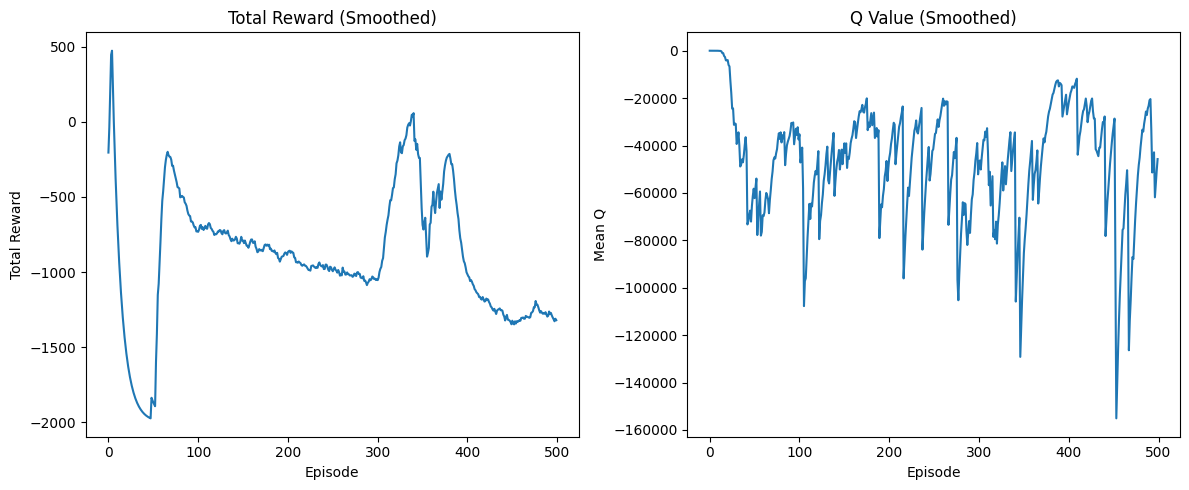

In [8]:
# 使用平滑函数对数据进行平滑处理
def smooth(data, weight=0.9):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_value = last * weight + (1 - weight) * point
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

# 对奖励历史和Q值历史进行平滑
smoothed_reward_history = smooth(reward_history)
smoothed_q_value_history = smooth(q_value_history)

# 绘制平滑后的曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Total Reward (Smoothed)")
plt.plot(smoothed_reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.title("Q Value (Smoothed)")
plt.plot(smoothed_q_value_history)
plt.xlabel("Episode")
plt.ylabel("Mean Q")

plt.tight_layout()
plt.show()


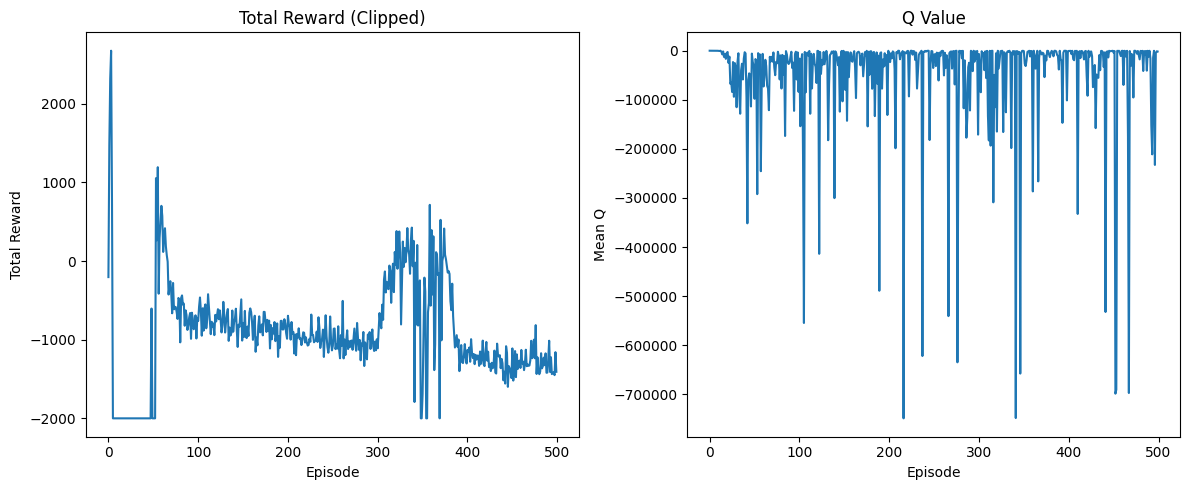

In [7]:
# 对 reward_history 中小于 -1000 的值进行修改，将其设置为 -1000
reward_history = [max(r, -2000) for r in reward_history]

# 重新绘制曲线，观察修改后的效果
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Total Reward (Clipped)")
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.title("Q Value")
plt.plot(q_value_history)
plt.xlabel("Episode")
plt.ylabel("Mean Q")

plt.tight_layout()
plt.show()
